In [ ]:
# !pip install geopandas shapely folium openpyxl contextily

In [1]:
import time
import pandas as pd
import geopandas as gpd
from shapely import wkt
from tqdm import tqdm

In [2]:
# Making my dataframe from the data
df = pd.read_excel('Vehicle_Crashes_in_Iowa_20250410.xlsx')

# Removing blank rows
df = df[df['Location'].notna()]
df = df[df['Location'].str.strip() != ""]

# Converting *valid* WKT strings into geometry objects
df['geometry'] = df['Location'].apply(wkt.loads)

# Creating a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.crs = "EPSG:4326"  # WGS84 (latitude and longitude)

# Dropping any points where x and y are close to zero
tol = 1  # tolerance threshold
gdf = gdf[~((gdf.geometry.x.abs() < tol) & (gdf.geometry.y.abs() < tol))]

Plotting markers: 100%|██████████████████████████████████████████████████████| 606123/606123 [04:36<00:00, 2193.97it/s]


plt.savefig() took 84.65 seconds
Static map saved as 'static_map.png'.


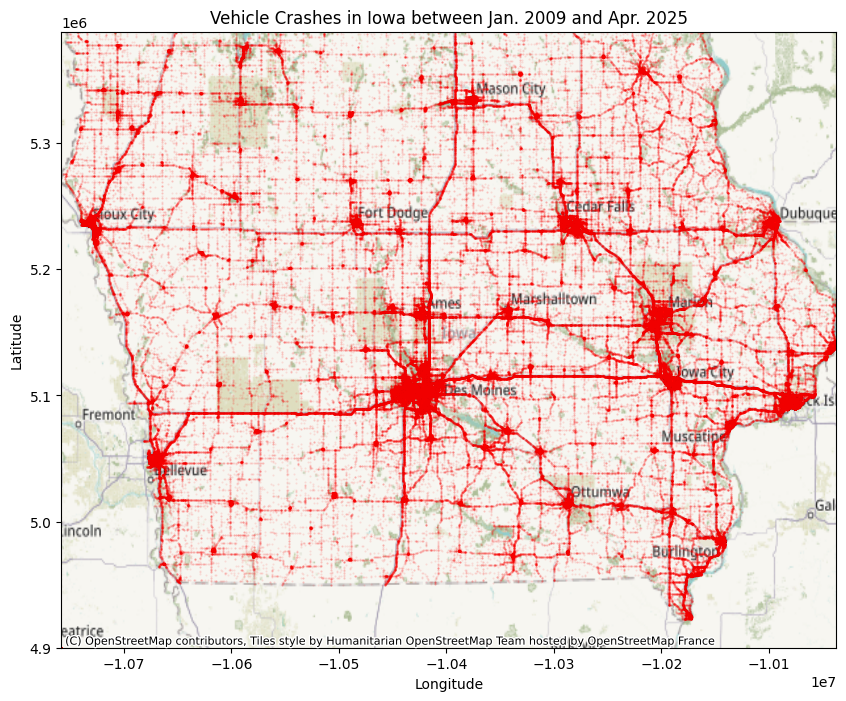

In [5]:
import matplotlib.pyplot as plt
import contextily as ctx

# Converting the CRS to EPSG:3857 to overlay on a basemap (Contextily requirement)
gdf = gdf.to_crs(epsg=3857)

# Creating a Matplotlib figure and axis
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title("Vehicle Crashes in Iowa between Jan. 2009 and Apr. 2025")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Setting up a base map
xmin, ymin, xmax, ymax = gdf.total_bounds
ax.set_xlim(xmin - 1, xmax + 1)
ax.set_ylim(ymin - 1, ymax + 1)

# Adding markers to the plot (also with a progress bar)
for idx, row in tqdm(gdf.iterrows(), total=gdf.shape[0], desc="Plotting markers"):
    ax.plot(row.geometry.x, row.geometry.y, marker='.', color='red', markersize=1, alpha=0.1)

# Underlaying the base map
ctx.add_basemap(ax, crs=gdf.crs)

# Saving the static map to an HTML file
# Also, measuring the time it takes to save the static map as an image
start_time = time.time()
plt.savefig("static_map.png")
end_time = time.time()
print(f"plt.savefig() took {end_time - start_time:.2f} seconds")
print("Static map saved as 'static_map.png'.")
# plt.show()

In [ ]:
import folium
from folium.plugins import MarkerCluster

# Calculating center of the map from the valid points
center_lat = gdf.geometry.y.mean()
center_lon = gdf.geometry.x.mean()

# Creating a Folium map centered at the calculated average location
m = folium.Map(location=[center_lat, center_lon], zoom_start=6)

# Initializing a MarkerCluster to group markers (reduces processing time)
marker_cluster = MarkerCluster().add_to(m)

# Adding markers for each valid coordinate
for idx, row in tqdm(gdf.iterrows(), total=gdf.shape[0], desc="Adding markers"):
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=f"Point {idx + 1}"
    ).add_to(m)

# Saving the interactive map to an HTML file
# Also, measuring the time it takes to save the map
start_time = time.time()
m.save("interactive_map.html")
end_time = time.time()
print(f"m.save() took {end_time - start_time:.2f} seconds")
print("Interactive map saved as 'interactive_map.html'. Open this file in a web browser to view the map.")